In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.0


In [2]:
## loading train_dataset
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname='iris_training.csv',origin=train_dataset_url)
print(f"Local copy of the dataset file: {train_dataset_fp}")


Local copy of the dataset file: /Users/kl/.keras/datasets/iris_training.csv


In [3]:
## loading test dataset
test_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
test_dataset_fp = tf.keras.utils.get_file(fname='iris_test.csv',
				origin=test_dataset_url)
print(f"Local copy of the test dataset file: {test_dataset_fp}")


Local copy of the test dataset file: /Users/kl/.keras/datasets/iris_test.csv


In [4]:
## columns name of the train_dataset
feature_names = [
    'sepal_length',
    'sepal_width',
    'petal_length',
    'petal_width'
]

label_name = 'species'
column_names = feature_names + [label_name]

print(f"Features: {feature_names}")
print(f"Label: {label_name}")

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [5]:
## Reading the datasets from the csv
import pandas as pd
batch_size = 32

train_df = pd.read_csv(
    train_dataset_fp,
    skiprows=1,
    names=column_names
)

features_df = train_df[feature_names]
label_df = train_df[label_name]

# Set the train dataset to have a batch size of 32
train_dataset = tf.data.Dataset.from_tensor_slices((features_df,label_df)).batch(batch_size)


Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



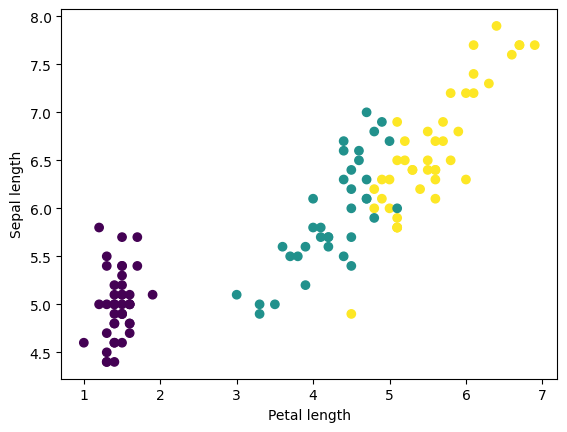

In [12]:
## Use matplotlib to visualize the dataset we get.
plt.scatter(
    features_df['petal_length'],
	features_df['sepal_length'],
	c=label_df,
	cmap='viridis'
)

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [13]:
test_df = pd.read_csv(test_dataset_fp,skiprows=1,names=column_names)
features_df = test_df[feature_names]
label_df = test_df[label_name]

test_dataset = tf.data.Dataset.from_tensor_slices((features_df,label_df)).batch(batch_size)

In [14]:
from tensorflow import keras

inputs = keras.Input(shape=(4,))
h1 = keras.layers.Dense(10,activation=tf.nn.relu)(inputs)
h2 = keras.layers.Dense(10,activation=tf.nn.relu)(h1)
outputs = keras.layers.Dense(3)(h2)
model = keras.Model(inputs=inputs, outputs=outputs, name="iris_model")

model.summary()

Model: "iris_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [15]:
## Makes predictions based on untrained weights and bias
next_batch_dataset = next(iter(train_dataset))
features,labels = next_batch_dataset
predictions = model(features)
predictions[:5]

## Use softmax to convert the number to probabilities
tf.nn.softmax(predictions[:5])

## Showing prediction results.
print(f"Prediction: {tf.argmax(predictions, axis=1)}")
print(f"    Labels: {labels}")

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [2 1 2 0 0 0 0 2 1 0 1 1 0 0 2 1 2 2 2 0 2 2 0 2 2 0 1 2 1 1 1 1]


In [16]:
## Define loss(The difference between the predictions made and the true value) as Sparse Categorical Cross Entropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [17]:
## Define loss function
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print(f"Loss test: {l}")

Loss test: 1.2078511714935303


In [19]:
## gradient descents for the models with the input and targets
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

## Set optimizers to be Stochastic Gradient Descent
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)

In [20]:
## Single step for training
loss_value, grads = grad(model, features, labels)

print(f"Step: {optimizer.iterations.numpy()}, Initial Loss: {loss_value.numpy()}")

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print(f"Step: {optimizer.iterations.numpy()}, Loss: {loss(model, features, labels, training=True).numpy()}")

Step: 0, Initial Loss: 1.2078511714935303
Step: 1, Loss: 1.200047492980957


In [21]:
## Training Loop for multiple optimization steps
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print(f"Epoch {epoch:03d}: Loss: {epoch_loss_avg.result():.3f}, Accuracy: {epoch_accuracy.result():.3%}")


Epoch 000: Loss: 1.172, Accuracy: 35.000%
Epoch 050: Loss: 0.910, Accuracy: 64.167%
Epoch 100: Loss: 0.597, Accuracy: 87.500%
Epoch 150: Loss: 0.385, Accuracy: 90.833%
Epoch 200: Loss: 0.283, Accuracy: 94.167%


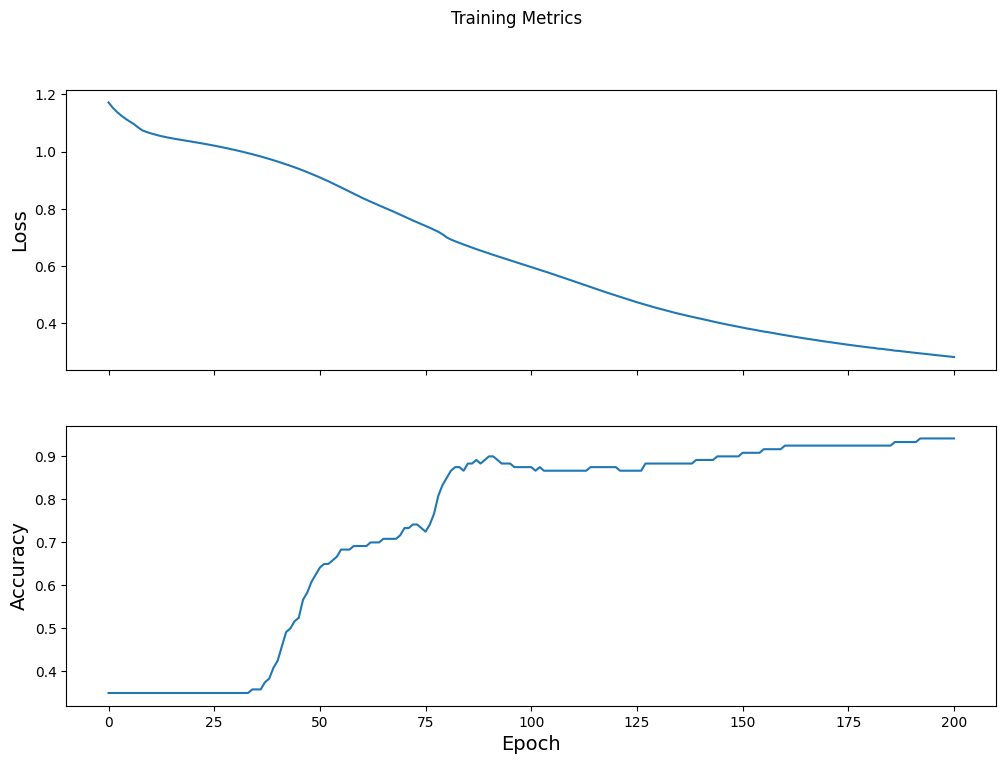

In [22]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()


In [23]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print(f"Test set accuracy: {test_accuracy.result():.3%}")


Test set accuracy: 93.333%


In [24]:
model.save('./model', overwrite=True)

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets
